<a href="https://colab.research.google.com/github/italolima04/monitoria-probabilidade-estatistica/blob/master/Pesquisa-PID/Redes_Neurais_TT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#Importando Bibliotecas.
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Importando os Dados e Criando Data Frame a Partir destes.
data = pd.read_csv('Tweets_Mg.csv')
data.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**A base de dados do Twitter e contém termos referentes a educação e a política do Estado de Minas Gerais.**

In [14]:
#Visualizando a Estrutura dos Dados.
data.shape

(8199, 26)

In [15]:
#Verificando as Colunas do Data Frame.
data.columns

Index(['Unnamed: 0', 'Created At', 'Text', 'Geo Coordinates.latitude',
       'Geo Coordinates.longitude', 'User Location', 'Username',
       'User Screen Name', 'Retweet Count', 'Classificacao', 'Observação',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'],
      dtype='object')

In [16]:
#Verificando a Presença de Valores Nulos nos Dados.
data.isna().sum()

Unnamed: 0                      0
Created At                      0
Text                            0
Geo Coordinates.latitude     8095
Geo Coordinates.longitude    8095
User Location                2710
Username                        0
User Screen Name                0
Retweet Count                   0
Classificacao                   0
Observação                   8198
Unnamed: 10                  8199
Unnamed: 11                  8199
Unnamed: 12                  8199
Unnamed: 13                  8199
Unnamed: 14                  8199
Unnamed: 15                  8199
Unnamed: 16                  8199
Unnamed: 17                  8199
Unnamed: 18                  8199
Unnamed: 19                  8199
Unnamed: 20                  8199
Unnamed: 21                  8199
Unnamed: 22                  8199
Unnamed: 23                  8199
Unnamed: 24                  8199
dtype: int64

**Observa-se que há muitas Colunas desnecessárias para o estudo. Isso se deve ao fato de que ao utilizar a API do Twitter para Coleta de dados ela retorna muitas informações descritivas para tais tweets.**

**Uma das vantagens de se utilizar Deep Learning é a menor exigência de feature engineer (Processo denominado para a criação de novas features a partir das existentes).**

In [17]:
#Removendo Dados duplicados na coluna de Texto.
data.drop_duplicates(['Text'], inplace=True)

In [18]:
#Verificando a nova Estrutura dos Data Frame após a remoção dos dados duplicados.
data.shape

(5765, 26)

In [19]:
data['Classificacao'].unique()

array(['Neutro', 'Negativo', 'Positivo'], dtype=object)

In [20]:
#Verificando a distribuição das classificações para os Tweets.
data['Classificacao'].value_counts()

Positivo    2840
Neutro      1974
Negativo     951
Name: Classificacao, dtype: int64

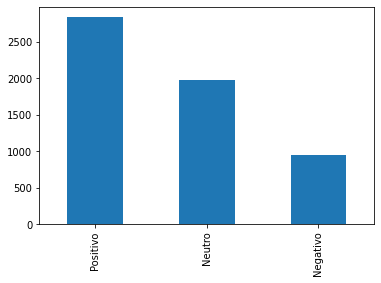

In [21]:
#Plotando Gráfico para visualização da Distribuição acima..
data['Classificacao'].value_counts().plot(kind='bar');

**Nessa primeira abordagem iremos trabalhar apenas com a Classificação Binária, portanto somente os sentimentos Positivos e Negativos serão utilizados.**

In [22]:
#Filtrando os dados (Linhas com Classificação de Sentimento diferente de 'Neutro')
data = data.loc[data.Classificacao != 'Neutro', :]

In [23]:
#Verificando a nova distribuição das classificações para os Tweets.
data['Classificacao'].value_counts()

Positivo    2840
Negativo     951
Name: Classificacao, dtype: int64

In [24]:
#Verificando a estrutura final dos dados que serão utilizados.
data.shape

(3791, 26)

**Como podemos ver, a coluna para Classificação apresenta caráter textual, portanto precisamos tornar esses dados como numéricos.**

In [25]:
#Atribuindo 1 para os sentimentos Positivos e 0 para os Negativos.
data.loc[data.Classificacao == 'Positivo', 'Classificacao'] = 1
data.loc[data.Classificacao == 'Negativo', 'Classificacao'] = 0

In [26]:
data.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Wed Jan 04 22:55:08 +0000 2017,"""BB e governo de Minas travam disputa sobre de...",NaN,NaN,NaN,Minas Previ,MinasPrevi,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12,Mon Jan 09 16:06:23 +0000 2017,"""erro desconhecido"" é mato! Aliás, é da secret...",NaN,NaN,"Santo Antônio do Monte, Brasil",Roberta de Oliveira,betavox,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16,Thu Jan 05 03:26:49 +0000 2017,"""Mesmo sem muito dinheiro no caixa o governo d...",NaN,NaN,NaN,Gê de Alcaniz,Gdealcaniz,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,25,Thu Jan 05 15:37:13 +0000 2017,"""uso de aeronave pertencente ao Estado de MG,...",NaN,NaN,Fortaleza - Ceará - Brasil,Vitor.R.,vitorr82,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Manipulando somente as colunas que serão utilizadas e armazenando nas variváveis x e y (Padrão de Projetos de Machine Learning)**

In [27]:
x = data['Text']

In [28]:
y = data['Classificacao']

In [29]:
y

4       0
8       0
12      0
16      0
25      0
       ..
8194    1
8195    1
8196    1
8197    1
8198    1
Name: Classificacao, Length: 3791, dtype: object

**Devido ao fato de os dados serem proveninentes de uma rede social, se faz necessária uma etapa de pré-processamento nos mesmos.**

In [30]:
def Preprocessa_dados(instancia):
      instancia = re.sub(r"http\S+", "", instancia).lower().replace('.', '').replace(';','').replace('-','').replace(':', '').replace(')', '')
      stopwords = set(nltk.corpus.stopwords.words('portuguese'))
      palavras = [i for i in instancia.split() if not i in stopwords]
      return (" ".join(palavras))

**Função que remove links, sinais de pontuação, torna todos caracteres minúsculos e remove as stopwords através da biblioteca NLTK.**

In [31]:
#Visualizando formato do Texto antes do Pré-Processamento.
x[:10]

4     ��� PSOL vai questionar aumento de vereadores ...
8     "BB e governo de Minas travam disputa sobre de...
12    "erro desconhecido" é mato! Aliás, é da secret...
16    "Mesmo sem muito dinheiro no caixa o governo d...
25    "uso de aeronave pertencente ao  Estado de MG,...
29    #Alerta - Nome da CEEE é utilizado em golpe no...
43    #beta #betalab #mg Governo em calamidade finan...
65    #DefesaAgropecuária "Governo de Minas Gerais a...
66    #EBC Governo de Minas investiga casos suspeito...
72    #i5gornascimento @i5gornascimento g1 Prefeito ...
Name: Text, dtype: object

In [32]:
#Aplicando a Função nos dados.
x = [Preprocessa_dados(i) for i in x]

In [33]:
#Visualizando formato do Texto após o Pré-Processamento.
x[:10]

['��� psol vai questionar aumento vereadores prefeito bh justiça politica estado minas',
 '"bb governo minas travam disputa sobre depósitos judiciais"',
 '"erro desconhecido" mato! aliás, secretaria estadual fazenda tá assim mg precisa dinheiro não, governador?',
 '"mesmo dinheiro caixa governo minas gerais compra 2 (dois helicópteros" dois helicópteros minas gerais #2017 s1',
 '"uso aeronave pertencente estado mg, domingo, p/ fins pessoais, claro desvio finalidade"',
 '#alerta nome ceee utilizado golpe estado',
 '#beta #betalab #mg governo calamidade financeira bb avisa justiça minas tem…',
 '#defesaagropecuária "governo minas gerais aposta arranjos produtivos locais" #ritda',
 '#ebc governo minas investiga casos suspeitos febre amarela malária estado',
 '#i5gornascimento @i5gornascimento g1 prefeito aimorés decreta estado emergência administrativa']

In [34]:
#Tornando os dados (Label) como um Array.
y = np.asarray(y).astype('float32')

In [35]:
y

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

**Da mesma forma que se fez necessário tornar o nosso label numérico, também devemos fazer o mesmo para o Texto.**

Iremos agora Tokenizare depois Vetorizar esses dados de Texto, tornando-os uma matriz numérica.

In [36]:
#A partir da biblioteca Keras instanciando o Tokenizar e definindo que serão utilizada as 10000 palavras mais comuns. 
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)

Using TensorFlow backend.


In [37]:
#Aplicando a Tokenização nos dados.
tokenizer.fit_on_texts(x)

In [38]:
sequences = tokenizer.texts_to_sequences(x)

**É atribuído um número para cada palavra encontrada no Léxico (Dados de Texto)**

In [39]:
#As frases agora são formadas por números.
sequences

[[943, 793, 167, 944, 577, 794, 141, 178, 30, 121, 19, 2],
 [33, 4, 2, 369, 370, 148, 104, 91],
 [1811, 1812, 646, 1188, 78, 698, 199, 647, 493, 1, 1189, 203, 945, 41],
 [699, 203, 946, 4, 2, 13, 23, 168, 10, 21, 10, 21, 2, 13, 144, 1813],
 [252, 1190, 1814, 19, 1, 1191, 339, 1815, 1816, 1192, 1193, 1817],
 [1194, 1195, 1818, 1819, 947, 19],
 [430, 431, 1, 4, 17, 25, 33, 36, 30, 2, 1820],
 [1821, 4, 2, 13, 1822, 1823, 1824, 1825, 1826],
 [1196, 4, 2, 700, 179, 56, 7, 8, 1197, 19],
 [190, 190, 92, 141, 406, 106, 19, 318, 407],
 [2, 167, 795, 796, 578, 797, 371, 19],
 [2, 167, 795, 796, 578, 797, 371, 19],
 [798, 17, 25, 4, 1, 23, 10, 21, 948],
 [798, 252, 104, 91, 4, 319, 408, 1, 1827],
 [70, 33, 36, 30, 4, 1, 32, 42, 43, 6, 320],
 [799, 4, 1828, 17, 25, 4, 1, 23, 10, 21],
 [1198,
  107,
  1199,
  1200,
  1201,
  494,
  1202,
  99,
  1829,
  1203,
  1204,
  17,
  25,
  1,
  23,
  168,
  21],
 [107,
  1198,
  1202,
  1199,
  1200,
  432,
  1201,
  1830,
  33,
  149,
  2,
  28,
  154,
  1

In [40]:
from keras import preprocessing

In [41]:
#Tornando-os uma matriz.
sequences = preprocessing.sequence.pad_sequences(sequences)

In [42]:
sequences

array([[   0,    0,    0, ...,  121,   19,    2],
       [   0,    0,    0, ...,  148,  104,   91],
       [   0,    0,    0, ...,  203,  945,   41],
       ...,
       [   0,    0,    0, ...,  214,  224,   61],
       [   0,    0,    0, ..., 3604, 1773, 3605],
       [   0,    0,    0, ...,    1,  686,  687]], dtype=int32)

**É hora de criar o Modelo, utilizaremos 3 camadas para a Rede.**

In [43]:
from keras import models
from keras import layers

In [44]:
#Criando o Modelo.
model = models.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
#Configurando os Parâmetros para a Rede.
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
#Dividindo os dados em Aproximadamente 80% para treino e 20% para validação.
partial_x_train = sequences[:3032]
x_val = sequences[3032:]

In [47]:
x_val

array([[   0,    0,    0, ...,  314,  140,  101],
       [   0,    0,    0, ...,    9,  571, 3433],
       [   0,    0,    0, ...,  220, 3434, 3435],
       ...,
       [   0,    0,    0, ...,  214,  224,   61],
       [   0,    0,    0, ..., 3604, 1773, 3605],
       [   0,    0,    0, ...,    1,  686,  687]], dtype=int32)

In [48]:
partial_x_train

array([[   0,    0,    0, ...,  121,   19,    2],
       [   0,    0,    0, ...,  148,  104,   91],
       [   0,    0,    0, ...,  203,  945,   41],
       ...,
       [   0,    0,    0, ...,  134,  317,  752],
       [   0,    0,    0, ...,  134,  317,  752],
       [   0,    0,    0, ...,    9,    3, 1674]], dtype=int32)

In [49]:
partial_y_train = y[:3032]
y_val = y[3032:]

In [50]:
partial_y_train

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [51]:
y_val

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [76]:
#Treinando o Modelo.
history = model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Train on 3032 samples, validate on 759 samples
Epoch 1/5
3032/3032 [==============================] - 0s 34us/step - loss: 0.4773 - accuracy: 0.7935 - val_loss: 0.6585 - val_accuracy: 0.8775
Epoch 2/5
3032/3032 [==============================] - 0s 28us/step - loss: 0.4729 - accuracy: 0.8024 - val_loss: 0.6205 - val_accuracy: 0.8827
Epoch 3/5
3032/3032 [==============================] - 0s 27us/step - loss: 0.4883 - accuracy: 0.7935 - val_loss: 0.6478 - val_accuracy: 0.8906
Epoch 4/5
3032/3032 [==============================] - 0s 24us/step - loss: 0.4846 - accuracy: 0.7965 - val_loss: 0.8578 - val_accuracy: 0.8169
Epoch 5/5
3032/3032 [==============================] - 0s 25us/step - loss: 0.4847 - accuracy: 0.7912 - val_loss: 0.6015 - val_accuracy: 0.9249


In [77]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

**Verificando comportamento Gráfico da Perda e do Accuracy do Modelo.**

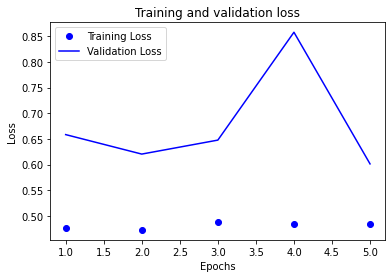

In [78]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

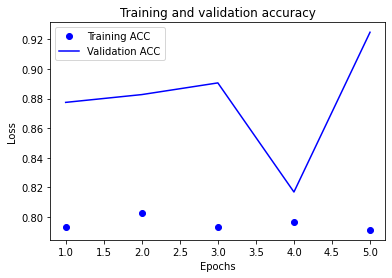

In [79]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training ACC')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation ACC')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Verificando Resultados.**

In [80]:
results = model.evaluate(x_val, y_val)
print(results)

759/759 [==============================] - 0s 41us/step
[0.6014602051186467, 0.9249011874198914]
